In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [194]:
# Remove EUR since exchange rates are based on EUR
df_filtered = df[df['currency'] != 'EUR'].copy()

# Convert date column to datetime format
df_filtered['date'] = pd.to_datetime(df_filtered['date'], format="%d/%m/%Y")

# Aggregate duplicate entries by averaging
df_filtered = df_filtered.groupby(['date', 'currency'], as_index=False).agg({'value': 'mean'})

# Pivot the table to have dates as index and currencies as columns
df_pivot = df_filtered.pivot(index='date', columns='currency', values='value')

# Sort data by date
df_pivot = df_pivot.sort_index()

# Fill missing values
scaled_df = df_pivot.fillna(method='ffill').fillna(method='bfill')
#Forward fill (ffill): Uses the last known value. Backward fill (bfill): Uses the next available value if ffill doesn't work.

# Normalize the data
scaler = MinMaxScaler(feature_range=(0.01, 0.99))  # Avoids numerical instability; avoid vanishing and exploding gradients
data_scaled = scaler.fit_transform(scaled_df)

# Convert back to DataFrame
scaled_df = pd.DataFrame(data_scaled, columns=df_pivot.columns, index=df_pivot.index)


C:\Users\wins\AppData\Local\Temp\ipykernel_10892\3519430812.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_df = df_pivot.fillna(method='ffill').fillna(method='bfill')


In [196]:
# Define function to create sequences
def create_sequences(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + horizon, :])
    return np.array(X), np.array(y)
    #window_size: Number of past days used as input (30, 60, 90, 120 days). 
    #horizon: Number of future days to predict (1, 7, 15, 30 days).

# Set sliding window sizes and multiple forecast horizons
window_sizes = [30, 60, 90, 120]  # Sliding windows for different forecasting tasks
forecast_horizons = [1, 7, 15, 30]  # Predict next 1, 7, 15, and 30 days

# Train-Test split (80-20)
split_index = int(len(scaled_df) * 0.8)
train_data, test_data = scaled_df.iloc[:split_index], scaled_df.iloc[split_index:]

# Prepare training and test sequences for different forecast horizons and window sizes
X_train_dict, y_train_dict, X_test_dict, y_test_dict = {}, {}, {}, {}
for window_size, horizon in zip(window_sizes, forecast_horizons):
    key = (window_size, horizon)
    X_train_dict[key], y_train_dict[key] = create_sequences(train_data.values, window_size, horizon)
    X_test_dict[key], y_test_dict[key] = create_sequences(test_data.values, window_size, horizon)

# Define LSTM model
def build_lstm_model(input_shape, output_size, dropout_rate=0.2):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(100, activation='relu', return_sequences=True),
        Dropout(dropout_rate),
        LSTM(50, activation='relu'),
        Dropout(dropout_rate),
        Dense(output_size * train_data.shape[1], activation='linear', name='output_layer'),
        Reshape((output_size, train_data.shape[1]))
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
    return model

In [198]:
# Model configurations
models_config = {
    "No Dropout": 0.0,
    "Dropout": 0.2
}

history_dict = {key: {} for key in X_train_dict.keys()}
predictions_dict = {key: {} for key in X_train_dict.keys()}

for key in X_train_dict.keys():
    window_size, horizon = key
    print(f"Training for window size {window_size} days and forecast horizon {horizon} days")
    for model_name, dropout_rate in models_config.items():
        model = build_lstm_model((window_size, train_data.shape[1]), horizon, dropout_rate)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            X_train_dict[key], y_train_dict[key],
            validation_data=(X_test_dict[key], y_test_dict[key]),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=[early_stopping]
        )
        
        history_dict[key][model_name] = history.history['mae']
        
        # Make predictions
        predictions = model.predict(X_test_dict[key])
        predictions_dict[key][model_name] = predictions

Training for window size 30 days and forecast horizon 1 days
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.3126 - mae: 0.4833 - val_loss: 0.3323 - val_mae: 0.4977
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2509 - mae: 0.4188 - val_loss: 0.2634 - val_mae: 0.4258
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1954 - mae: 0.3572 - val_loss: 0.2119 - val_mae: 0.3711
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1518 - mae: 0.3037 - val_loss: 0.1614 - val_mae: 0.3164
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1123 - mae: 0.2537 - val_loss: 0.1238 - val_mae: 0.2742
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0792 - mae: 0.2087 - val_loss: 0.0944 - val_mae: 0.2373
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0573 - mae: 0.1758 - val_loss: 0.0751 - val_mae: 0.2118
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0418 - mae: 0.1507 - val_loss: 0.0650 - val_mae: 0.

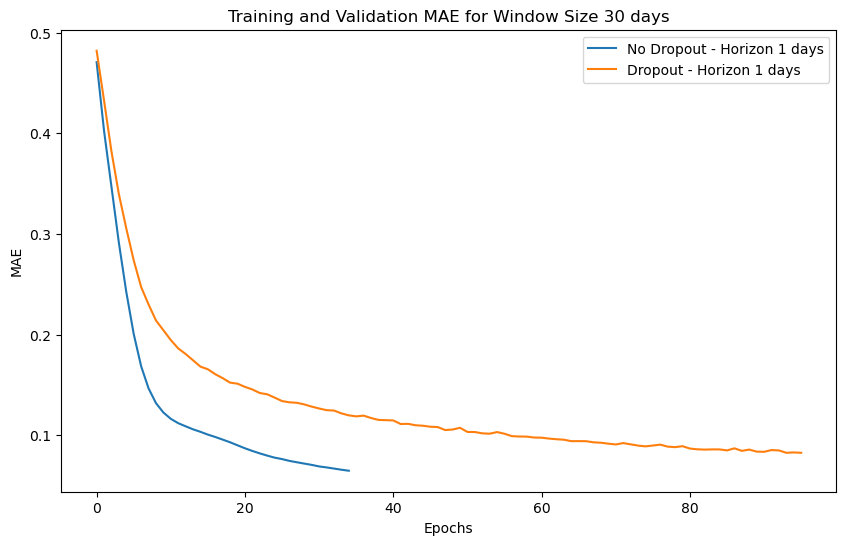

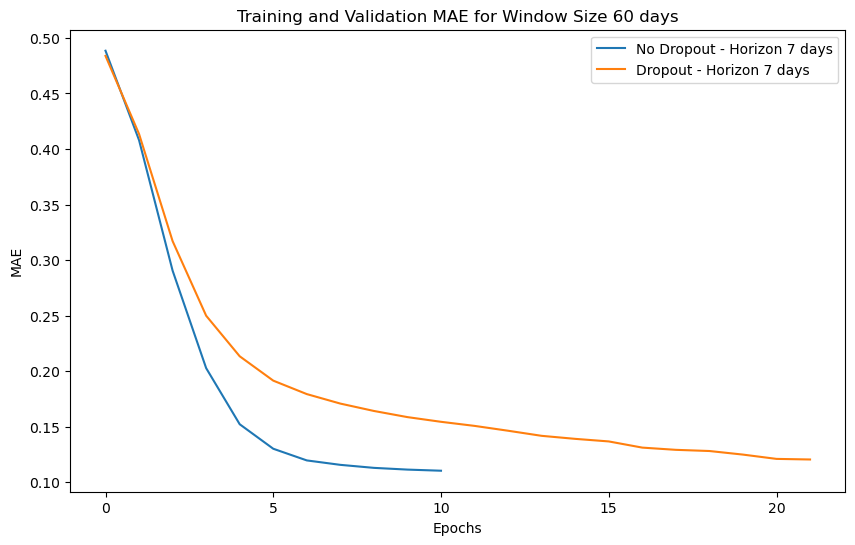

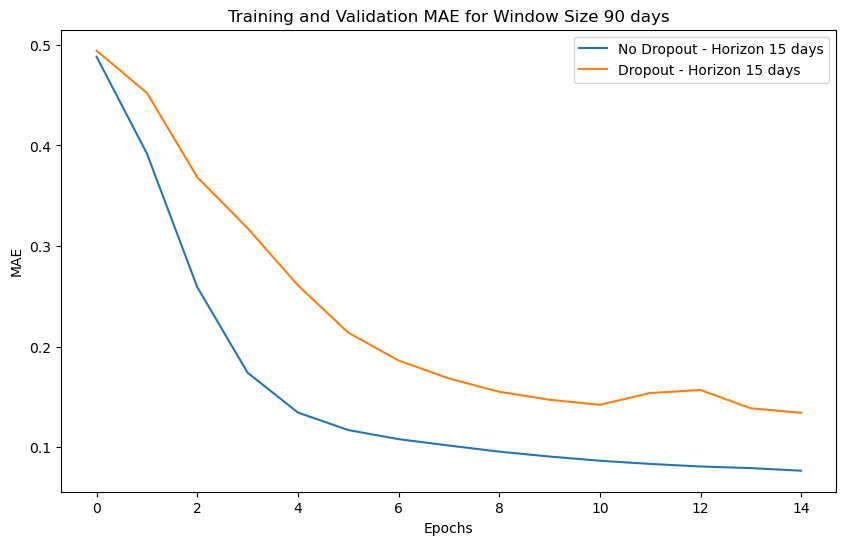

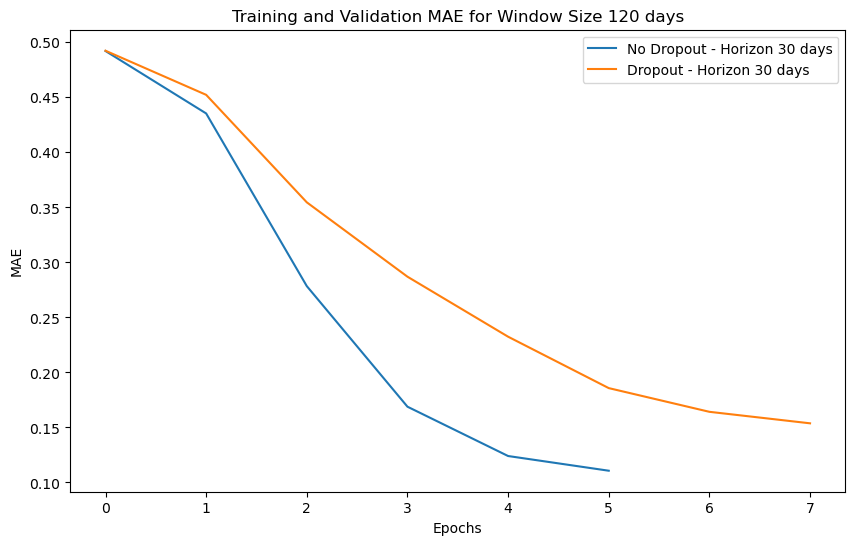

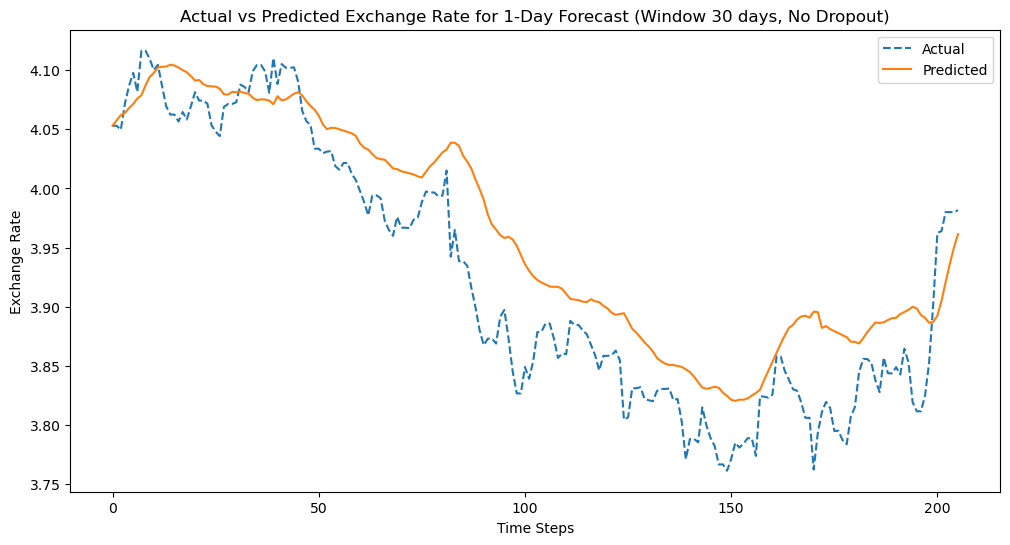

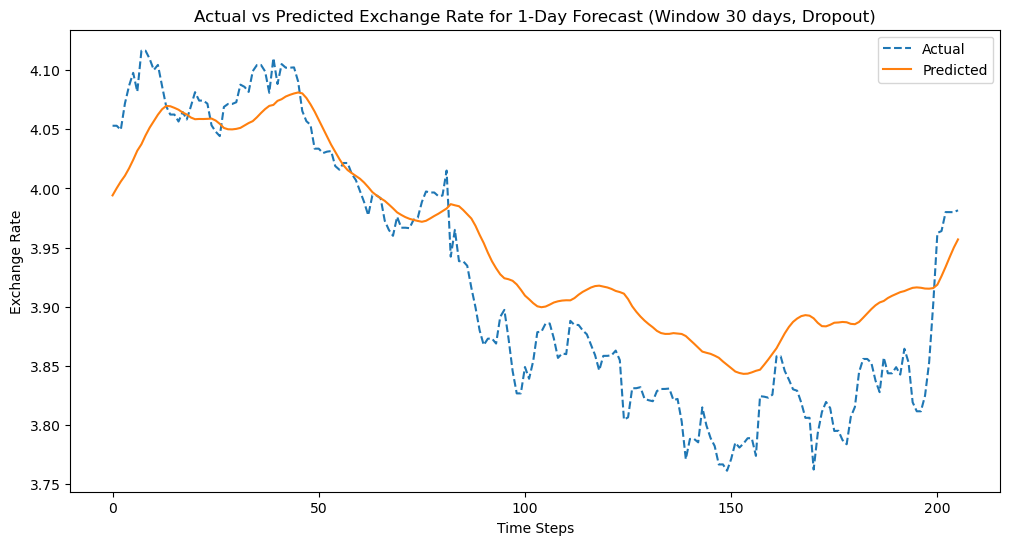

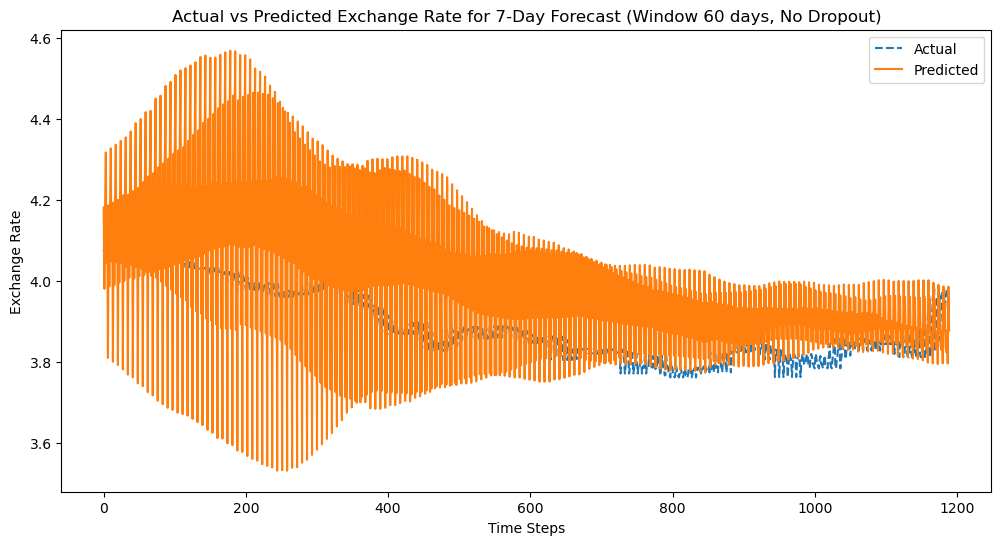

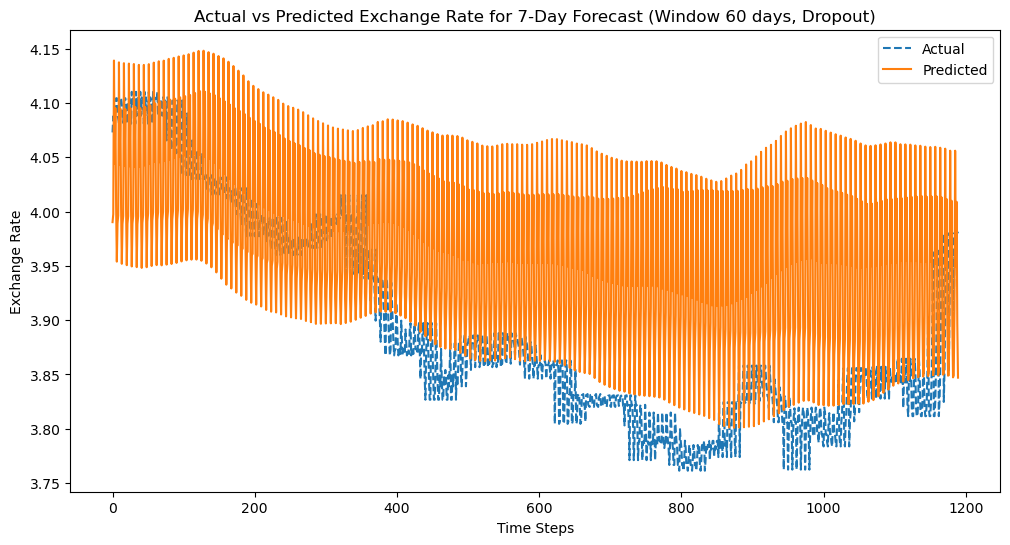

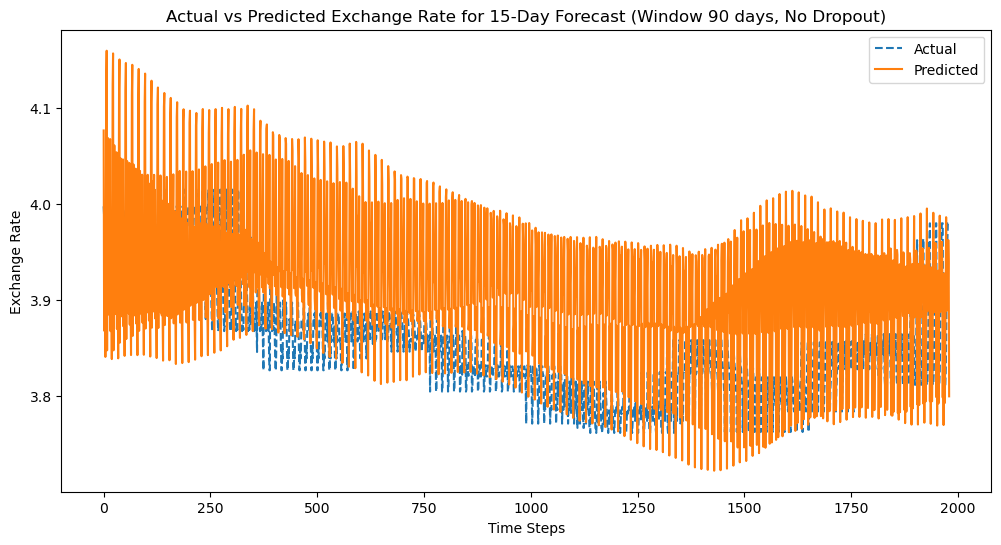

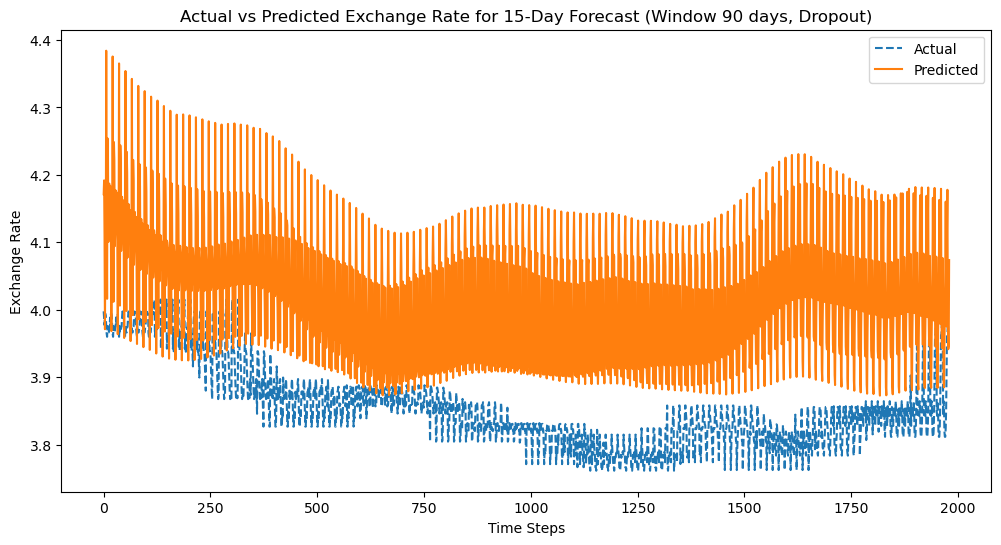

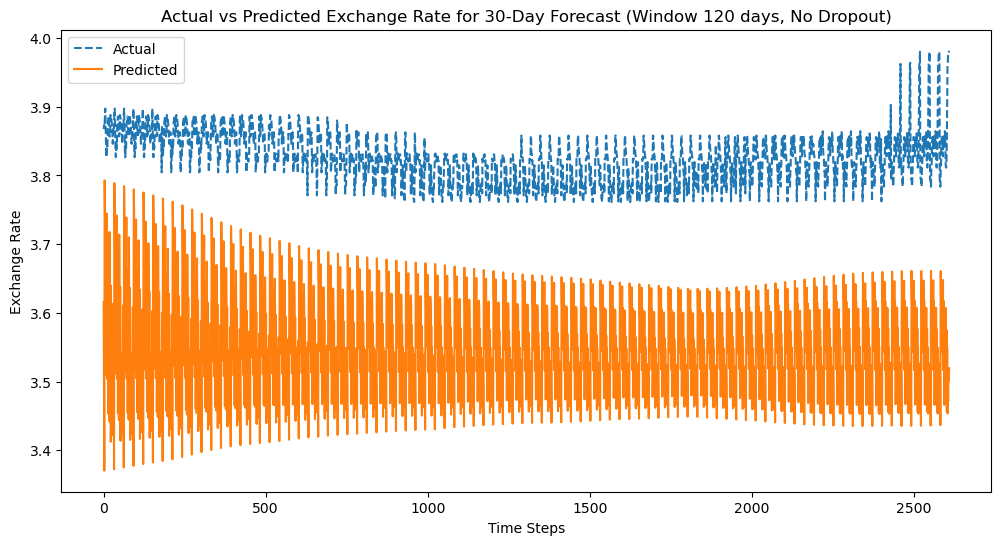

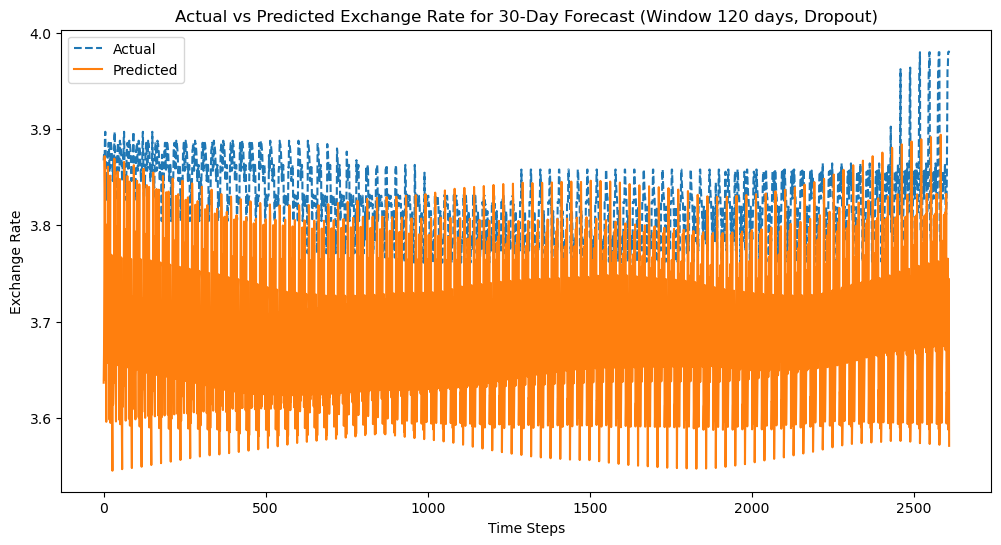

In [200]:
# Plot MAE for different forecast horizons on the same plot
for key in X_train_dict.keys():
    window_size, horizon = key
    plt.figure(figsize=(10, 6))
    for model_name, mae in history_dict[key].items():
        plt.plot(mae, label=f'{model_name} - Horizon {horizon} days')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.title(f'Training and Validation MAE for Window Size {window_size} days')
    plt.show()

# Inverse transform predictions and actual values and plot separately for each forecast horizon
for key in X_train_dict.keys():
    window_size, horizon = key
    for model_name in models_config.keys():
        actual_values = scaler.inverse_transform(y_test_dict[key].reshape(-1, scaled_df.shape[1]))
        predicted_values = scaler.inverse_transform(predictions_dict[key][model_name].reshape(-1, scaled_df.shape[1]))
        
        # Plot Actual vs Predicted separately for each horizon
        plt.figure(figsize=(12, 6))
        plt.plot(actual_values[:, 0], label='Actual', linestyle='dashed')
        plt.plot(predicted_values[:, 0], label='Predicted')
        plt.xlabel('Time Steps')
        plt.ylabel('Exchange Rate')
        plt.legend()
        plt.title(f'Actual vs Predicted Exchange Rate for {horizon}-Day Forecast (Window {window_size} days, {model_name})')
        plt.show()

In [ ]:
import os
print(os.path)